In [1410]:
import cv2
import numpy as np
from common_functions import *
from skimage.filters import threshold_minimum,threshold_otsu
from skimage.exposure import equalize_hist
from scipy.ndimage import binary_erosion,binary_closing,binary_opening,binary_dilation


In [1411]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


def kmeans(image_rgb,k,randomSeed = 42):
    cv2.setRNGSeed(randomSeed)

    # Reshape the image into a 2D array of pixels and 3 color values (RGB)
    pixel_values = image_rgb.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    # Define criteria, number of clusters (K), and apply K-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    #k = 2  # Number of clusters
    _, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Convert centers to uint8 (RGB values)
    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    segmented_image = segmented_image.reshape(image_rgb.shape)

    # Create a mask for the cluster corresponding to the statue
    l = labels.copy()
    labels = labels.flatten()
    mask = (labels == 0)  # Adjust based on which cluster corresponds to the statue
    segmented_mask = mask.reshape(image_rgb.shape[:2])

    # Apply mask to the original image
    statue_segmented = cv2.bitwise_and(image_rgb, image_rgb, mask=segmented_mask.astype(np.uint8))

    return labels,centers



In [1412]:
# Load the image
image = cv2.imread('../imgs/22.jpg')
k = 2
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
labels,centers = kmeans(image_rgb,k)
list = []


In [1413]:
def find_white_label_min(labels, centers, image_rgb):
    # Calculate the intensity of each center (sum of RGB values)
    intensities = np.sum(centers, axis=1)

    # Find the label corresponding to the brightest cluster (white)
    white_label = np.argmax(intensities)

    # Create a mask for pixels belonging to the white label
    white_mask = (labels == white_label)

    # Find the minimum value of the white-labeled pixels in the original image
    # Convert labels back to the 2D shape of the image
    white_pixels = image_rgb.reshape(-1, 3)[white_mask]
    min_white_value = np.min(np.sum(white_pixels, axis=1))  # Sum of RGB values

    return white_label, min_white_value

white_label, min_white_value = find_white_label_min(labels, centers, image_rgb)
print(white_label, min_white_value)

1 299


1


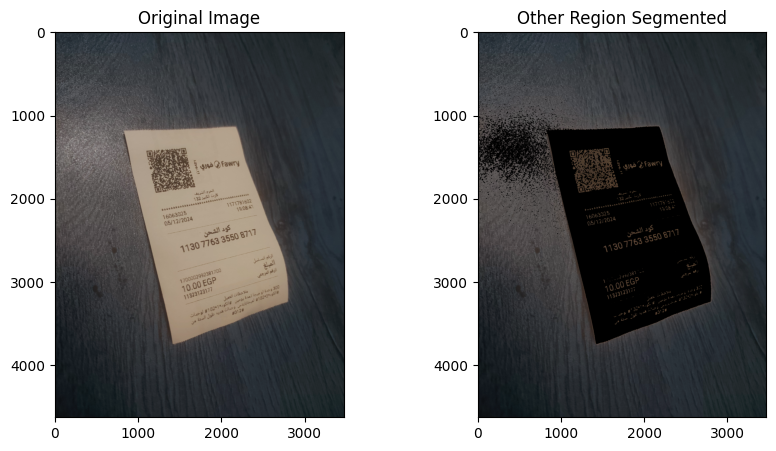

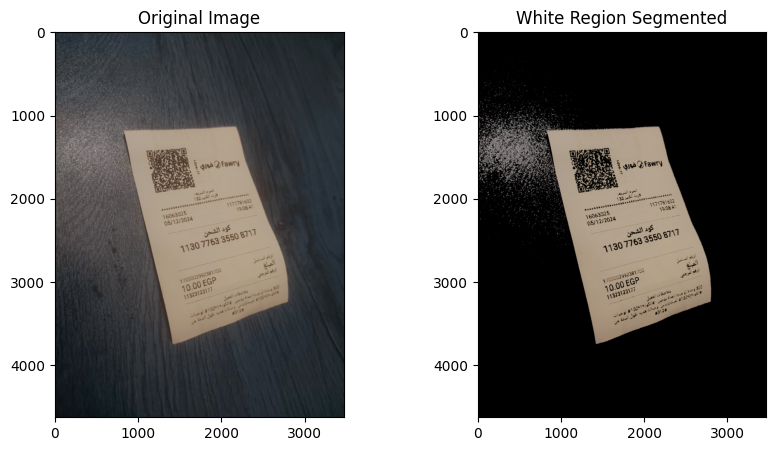

In [1414]:
white_label = np.argmax(np.sum(centers, axis=1))  # Identify the white region
print(white_label)

for i in range(2):
    mask = (labels == i)
    segmented_mask = mask.reshape(image_rgb.shape[:2])

    # Apply mask to the original image
    segmented_image = cv2.bitwise_and(image_rgb, image_rgb, mask=segmented_mask.astype(np.uint8))

    # Display results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    if i == white_label:
        plt.title("White Region Segmented")
    else:
        plt.title("Other Region Segmented")
    plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))

    plt.show()


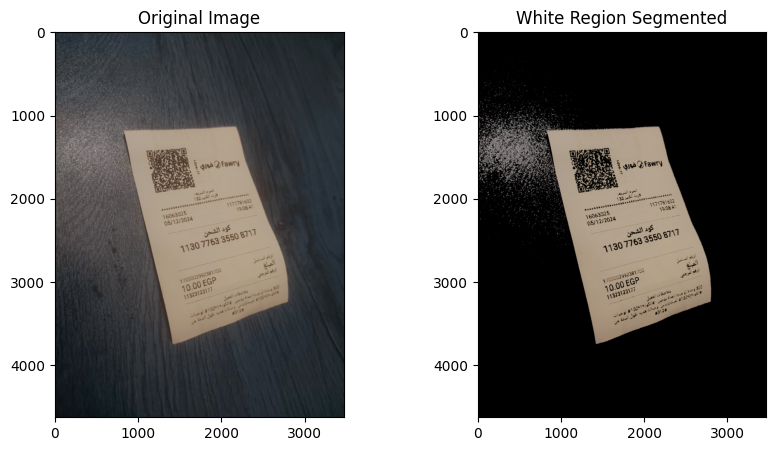

In [1415]:
mask = (labels == white_label)
segmented_mask = mask.reshape(image_rgb.shape[:2])

# Apply mask to the original image
segmented_image = cv2.bitwise_and(image_rgb, image_rgb, mask=segmented_mask.astype(np.uint8))

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image_rgb, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
if i == white_label:
    plt.title("White Region Segmented")
else:
    plt.title("Other Region Segmented")
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))

plt.show()

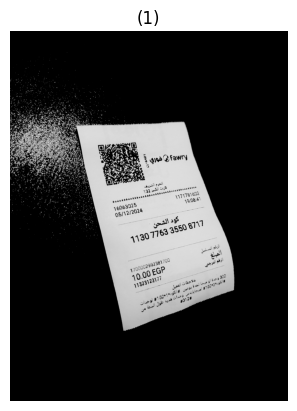

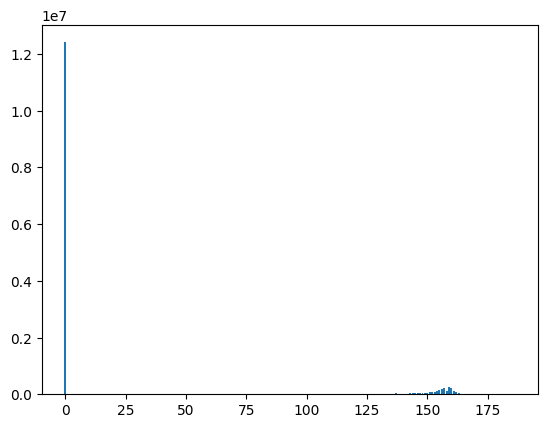

In [1416]:
segmentedImageRgb = rgb2gray(segmented_image)
show_images([segmentedImageRgb])
#print all intensities
showHist(segmentedImageRgb*255)






In [1417]:
print(segmentedImageRgb.max())

0.7308631372549019


In [1418]:
segmentedImageRgb = (segmentedImageRgb * 255).astype('uint8')

In [1419]:
from skimage.filters import threshold_local

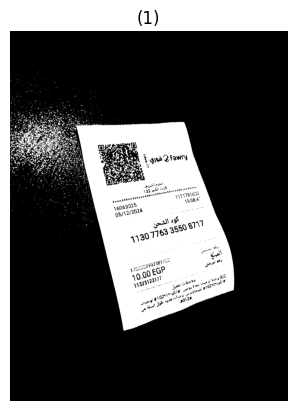

In [1420]:
#threshold = threshold_minimum(segmentedImageRgb) #first problem
#threshold = threshold_otsu(segmentedImageRgb) #second problem
#threshold = threshold_maximum(segmentedImageRgb) #third problem
threshold = 0.6 * segmentedImageRgb.max()
mask = segmentedImageRgb > threshold
binarySeg = np.zeros(segmentedImageRgb.shape)
binarySeg[mask] = 255
show_images([binarySeg])

In [1421]:
from skimage.measure import find_contours

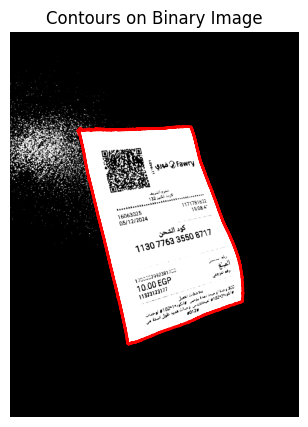

In [1422]:
contours = find_contours(binarySeg,0.8)
contours = [np.array(contour, dtype=np.int32) for contour in contours]
import matplotlib.pyplot as plt
#plot all contours
#plt.figure(figsize=(10, 5))
#plt.imshow(binarySeg.astype(bool), cmap='gray')  # Display the binary image
#plt.title("Contours on Binary Image")
#plt.axis("off")

#for c in contours:
 #   plt.plot(c[:, 1], c[:, 0], linewidth=2, color='red')  # Contours are in (y, x) format

#plt.show()



# Plot the binary image with contours
plt.figure(figsize=(10, 5))
plt.imshow(binarySeg.astype(bool), cmap='gray')  # Display the binary image
plt.title("Contours on Binary Image")
plt.axis("off")


# Plot each contour
maxC = max(contours, key=cv2.contourArea)
c = maxC

plt.plot(c[:, 1], c[:, 0], linewidth=2, color='red')  # Contours are in (y, x) format

plt.show()

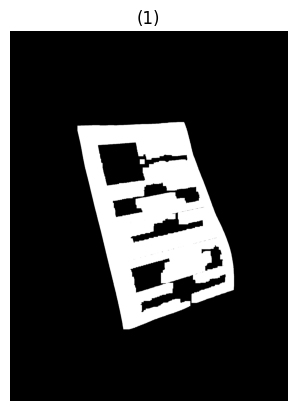

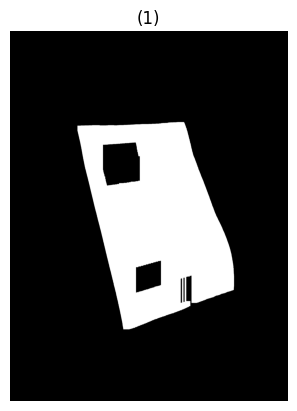

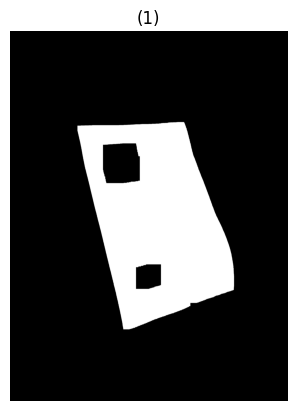

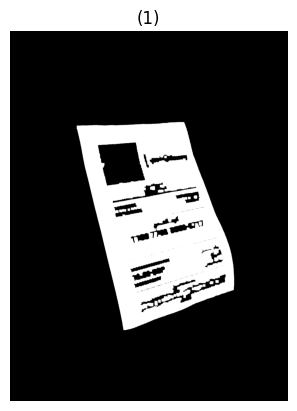

In [1423]:
#tarek's comment
se = np.ones([4,4])
#opened = binary_closing(binarySeg,np.ones((2,1)), iterations=50) #problem 2
#show_images([opened])
#opened = binary_opening(opened,np.ones((4,4)), iterations=50) #problem 2
#show_images([opened])
#opened = binary_closing(opened,np.ones((3,3)), iterations=20) #problem 2
#show_images([opened])
opened = binary_opening(binarySeg,np.ones((4,4)), iterations=20) #problem 2
show_images([opened])
opened = binary_closing(opened,np.ones((2,1)), iterations=300) #problem 2
show_images([opened])
opened = binary_closing(opened,np.ones((5,5)), iterations=40) #problem 2
show_images([opened])
opened = binary_opening(binarySeg,np.ones((3,3)), iterations=15) #problem 2
show_images([opened])


In [1424]:
from skimage.measure import find_contours

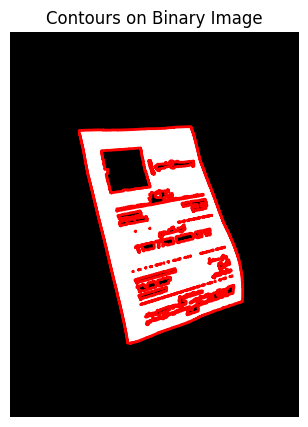

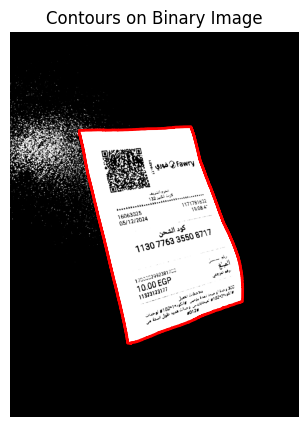

In [1425]:
contours = find_contours(opened,0.8)
contours = [np.array(contour, dtype=np.int32) for contour in contours]
import matplotlib.pyplot as plt
#plot all contours
plt.figure(figsize=(10, 5))
plt.imshow(opened.astype(bool), cmap='gray')  # Display the binary image
plt.title("Contours on Binary Image")
plt.axis("off")

for c in contours:
    plt.plot(c[:, 1], c[:, 0], linewidth=2, color='red')  # Contours are in (y, x) format

plt.show()



# Plot the binary image with contours
plt.figure(figsize=(10, 5))
plt.imshow(binarySeg.astype(bool), cmap='gray')  # Display the binary image
plt.title("Contours on Binary Image")
plt.axis("off")


# Plot each contour
maxC = max(contours, key=cv2.contourArea)
c = maxC

plt.plot(c[:, 1], c[:, 0], linewidth=2, color='red')  # Contours are in (y, x) format

plt.show()

In [1426]:
print(binarySeg.shape)

(4624, 3468)


In [1427]:
xMax = c[:,0].max()
yMax = c[:,1].max()

In [1428]:
#from here this is copied
def filter_reciept_contours(contours):
    """Filters contours to find a rectangular contour with 4 corners and a large area."""
    rectangular_contours = []
    max_area = 0
    reciept_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            peri = cv2.arcLength(contour, True)
            approx_polygon = cv2.approxPolyDP(contour, 0.015 * peri, True)
            #show me the contours on the image
            if area > max_area and len(approx_polygon) == 4:
                rectangular_contours.append(approx_polygon)
                reciept_contour = approx_polygon
                max_area = area
    return rectangular_contours, reciept_contour

In [1429]:
#top-left, top-right, bottom-right, bottom-left.
def find_polygon_corners(reciept_contour):
    """Identifies the corners of the detected polygon."""
    points = reciept_contour.reshape(4, 2)
    input_points = np.zeros((4, 2), dtype="float32")
    points_sum = points.sum(axis=1)
    input_points[0] = points[np.argmin(points_sum)]
    input_points[3] = points[np.argmax(points_sum)]
    points_diff = np.diff(points, axis=1)
    input_points[1] = points[np.argmin(points_diff)]
    input_points[2] = points[np.argmax(points_diff)]
    #show points on the image

    return input_points

In [1430]:
def find_corners_min_area_rect(receipt_contour):
    """Find corners of the minimum-area bounding rectangle."""
    # Get the minimum-area bounding rectangle
    rect = cv2.minAreaRect(receipt_contour)

    # Get the four corners of the rectangle
    box = cv2.boxPoints(rect)  # Returns corners in float32
    box = box.astype(int)  # Convert to integer values

    return box

In [1431]:
def transform_perspective(image, input_points):
    """Performs a perspective transformation on the image."""
    max_width = 650
    max_height = 1024
    converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])
    matrix = cv2.getPerspectiveTransform(input_points, converted_points)
    img_output = cv2.warpPerspective(image, matrix, (max_width, max_height))
    return img_output

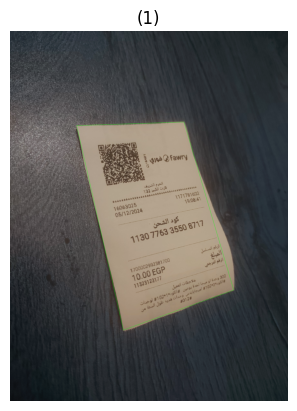

In [1432]:
def approximate_to_rectangle(c, max_iterations=100000, initial_epsilon_factor=0.09):
    """Iteratively approximates a contour to a rectangle with 4 corners."""
    epsilon_factor = initial_epsilon_factor
    for _ in range(max_iterations):
        peri = cv2.arcLength(c, True)
        approx_polygon = cv2.approxPolyDP(c, epsilon_factor * peri, True)
        
        # Check if the polygon has 4 corners
        if len(approx_polygon) == 4:
            return approx_polygon  # Successfully approximated to a rectangle
        
        # Reduce epsilon for finer approximation
        epsilon_factor *= 0.9  # Reduce by 10% each iteration
    
    # If no rectangle is found after max_iterations, return the last approximation
    return None  # Or return the last `approx_polygon` if you want

# Example usage
c = np.array([[p[1], p[0]] for p in c], dtype=np.int32)
reciept_contour = approximate_to_rectangle(c)
c = np.array([[p[1], p[0]] for p in c], dtype=np.int32)
#peri = cv2.arcLength(c, True)
#approx_polygon = cv2.approxPolyDP(c, 0.02 * peri, True)
#reciept_contour = approx_polygon
visualized_image = image.copy()
approx_polygon = reciept_contour

# Draw the approximated contour on the image
cv2.drawContours(visualized_image, [approx_polygon], -1, (0, 255, 0), 2)  # Green contour, thickness 2
show_images([visualized_image])

# Draw circles at each corner point
for point in approx_polygon:
    cv2.circle(visualized_image, tuple(point[0]), 5, (255, 0, 0), -1)  # Blue points





In [1433]:
import numpy as np

import numpy as np

def fix_outlier_point_with_distance(input_points):
    """
    Fixes an outlier point in the array of 4 points (top-left, top-right, bottom-right, bottom-left).
    Adjusts the outlier by reducing its distance from the centroid to align with the mean distance.
    """
    if len(input_points) != 4:
        raise ValueError("Input must contain exactly 4 points.")

    # Step 1: Calculate the centroid (center of all points)
    centroid = np.mean(input_points, axis=0)

    # Step 2: Calculate the distances of each point from the centroid
    distances = np.linalg.norm(input_points - centroid, axis=1)

    # Step 3: Identify the outlier point
    outlier_index = np.argmax(distances)

    # Step 4: Calculate the mean distance of the other three points
    valid_distances = np.delete(distances, outlier_index)
    mean_distance = np.mean(valid_distances)

    # Step 5: Calculate the difference and adjust the outlier
    distance_diff = distances[outlier_index] - mean_distance

    # Adjust the outlier coordinates proportionally
    outlier_point = input_points[outlier_index]
    direction_vector = outlier_point - centroid
    normalized_vector = direction_vector / np.linalg.norm(direction_vector)
    correction = normalized_vector * distance_diff
    corrected_point = outlier_point - correction

    # Step 6: Replace the outlier point with the corrected point
    input_points[outlier_index] = corrected_point

    return input_points



[[ 925.78326 1293.5168 ]
 [2169.      1137.     ]
 [1414.      3737.     ]
 [2790.      3237.     ]]


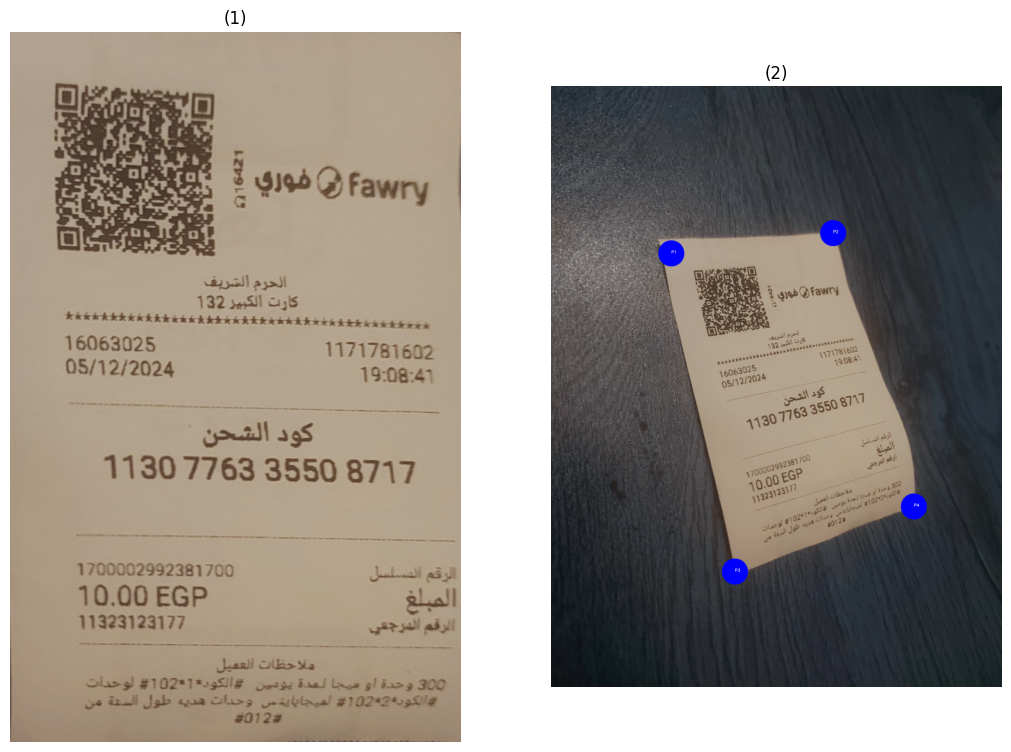

In [1434]:
input_points = find_polygon_corners(reciept_contour)
input_points = fix_outlier_point_with_distance(input_points)
#input_points = find_corners_min_area_rect(reciept_contour)
print(input_points)
#show points on the image
# Create a copy of the image to draw the points
image_with_points = image.copy()

# Draw each point on the image with larger circles
for point in input_points:
    cv2.circle(image_with_points, tuple(point.astype(int)), 100, (0, 0, 255), -1)  # Larger red circles

# Optionally, label the points for clarity
for i, point in enumerate(input_points):
    cv2.putText(
        image_with_points,
        f"P{i+1}",
        tuple(point.astype(int)),
        cv2.FONT_HERSHEY_SIMPLEX,
        1,  # Larger font size
        (255, 255, 255),  # White text
        2,  # Thicker text
        cv2.LINE_AA,
    )

    

img_output = transform_perspective(image, input_points)

show_images([img_output,image_with_points])

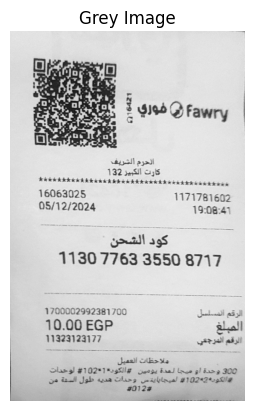

In [1435]:
receiptGrey = rgb2gray(img_output)
show_images([receiptGrey], ["Grey Image"])

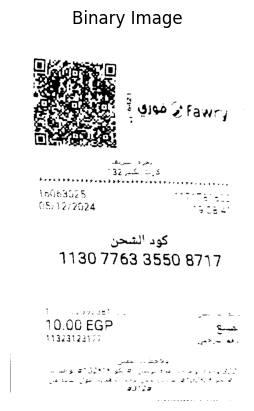

In [1436]:
receiptBinary = receiptGrey > threshold_minimum(receiptGrey)
show_images([receiptBinary], ["Binary Image"])

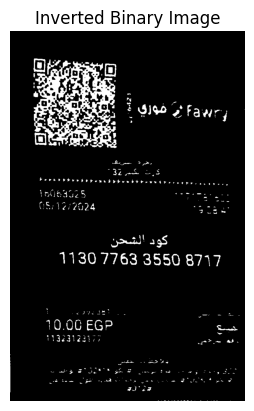

In [1437]:
receiptBinaryInverted = np.invert(receiptBinary)
show_images([receiptBinaryInverted], ["Inverted Binary Image"])

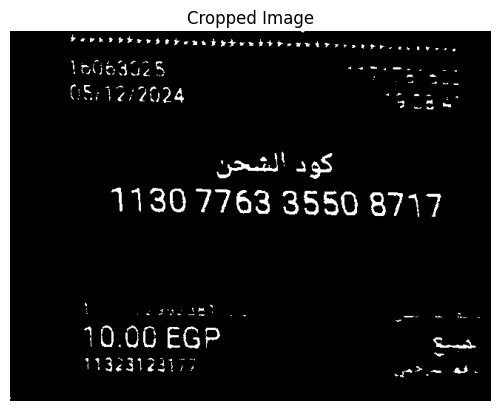

In [1438]:
receiptBinaryCropped = receiptBinaryInverted[400:900, 0:]
show_images([receiptBinaryCropped], ["Cropped Image"])

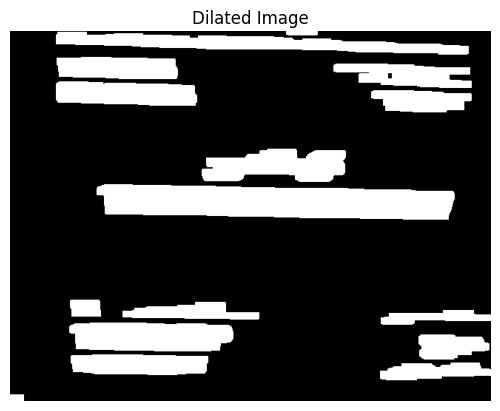

In [1439]:
#temp = binary_opening(receiptBinaryCropped,np.ones((2,2)),iterations=1)
binarydilated = binary_dilation(receiptBinaryCropped,np.ones((5,20)),iterations=2)
show_images([binarydilated], ["Dilated Image"])

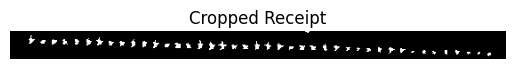

In [1440]:
#now crop the largest contour
contours = find_contours(binarydilated,0.8)
max_area = 0
max_contour = None
for contour in contours:
    if len(contour) > max_area:
        max_area = len(contour)
        max_contour = contour

min_x = int(np.min(max_contour[:,1]))
max_x = int(np.max(max_contour[:,1]))
min_y = int(np.min(max_contour[:,0]))
max_y = int(np.max(max_contour[:,0]))

cropped_receipt = receiptBinaryCropped[min_y:max_y,min_x:max_x]
show_images([cropped_receipt], ["Cropped Receipt"])

In [1441]:
img = cropped_receipt

Number of contours found: 48
Number of contours after filtering: 0


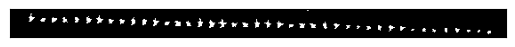

Current min_contour_size: 100
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


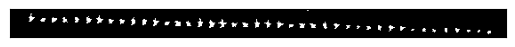

Current min_contour_size: 95
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


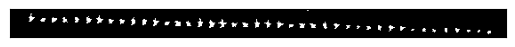

Current min_contour_size: 90
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


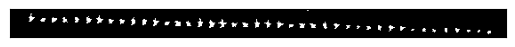

Current min_contour_size: 85
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


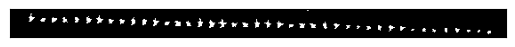

Current min_contour_size: 80
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


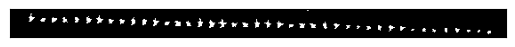

Current min_contour_size: 75
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


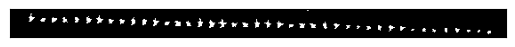

Current min_contour_size: 70
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


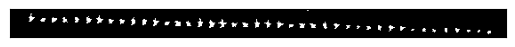

Current min_contour_size: 65
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


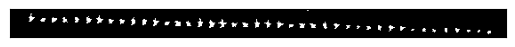

Current min_contour_size: 60
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


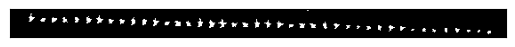

Current min_contour_size: 55
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


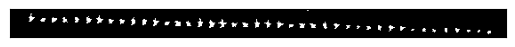

Current min_contour_size: 50
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 0


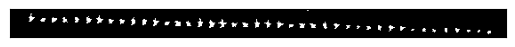

Current min_contour_size: 45
Number of letters: 0
Number of contours found: 48
Number of contours after filtering: 1


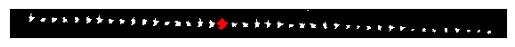

Current min_contour_size: 40
Number of letters: 1


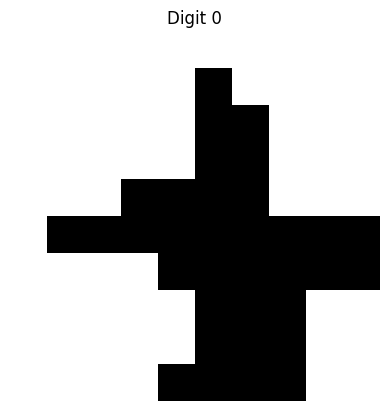

1
1


In [1442]:
import cv2
import os
import numpy as np
import heapq
from skimage.measure import find_contours
import matplotlib.pyplot as plt


# Apply erosion
#img = binary_closing(img, np.ones((2,1)), iterations=10)

def process_contours(img,min_contour_size = 100):
    global contours, queue, existing_regions, letters

    # Find contours of the digits
    contours = find_contours(img, 0.8)
    print("Number of contours found:", len(contours))

    # Keep only the big contours
    contours = [contour for contour in contours if contour.shape[0] > min_contour_size]
    print("Number of contours after filtering:", len(contours))

    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2, color='red')
    ax.axis('image')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

    queue = []
    existing_regions = []  # To store existing bounding boxes

    # Function to check intersection between bounding boxes
    def intersects(new_box, existing_boxes):
        new_x1, new_y1, new_x2, new_y2 = new_box
        for box in existing_boxes:
            x1, y1, x2, y2 = box
            if not (new_x2 < x1 or new_x1 > x2 or new_y2 < y1 or new_y1 > y2):
                return True  # Intersection found
        return False

    # Extract bounding boxes for contours
    for contour in contours:
        maxY = contour[:, 0].max()
        maxX = contour[:, 1].max()
        minY = contour[:, 0].min()
        minX = contour[:, 1].min()

        
        
        new_box = (minX, minY, maxX, maxY)
        if not intersects(new_box, existing_regions):
            # Push regions to a heap for sorting by X-coordinate
            heapq.heappush(queue, (minX, img[int(minY):int(maxY), int(minX):int(maxX)]))
            existing_regions.append(new_box)

    # Extract individual digit images
    letters = []
    while len(queue) > 0:
        img_digit = heapq.heappop(queue)[1]  # Extract the digit region
        img_digit = img_digit.astype(np.uint8)
        img_digit = img_digit.max() - img_digit  # Invert colors if necessary
        letters.append(img_digit)  # Append the digit image to the list

# Adjust contour size dynamically to get at least 16 letters
min_contour_size = 100
while True:
    process_contours(img,min_contour_size)
    print("Current min_contour_size:", min_contour_size)
    print("Number of letters:", len(letters))
    if len(letters) >= 16 or min_contour_size <= 40:
        break
    min_contour_size -= 5  # Reduce the contour size threshold incrementally

# Show extracted digit images
show_images(letters, ["Digit " + str(i) for i in range(len(letters))])
print(letters[0].max())
print(len(letters))


Number of images after splitting: 1


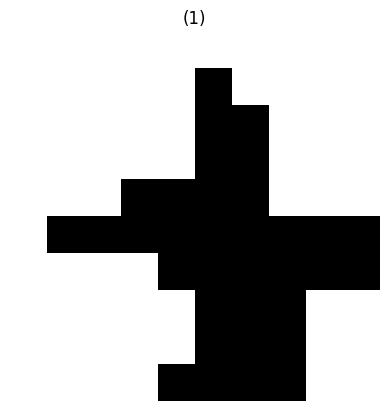

Number of images after splitting: 1


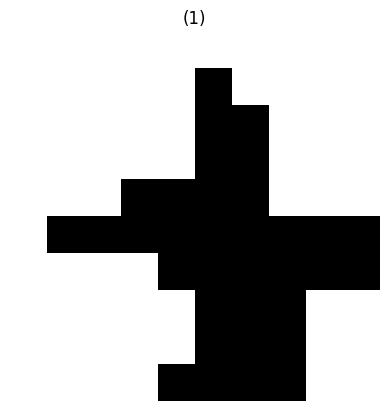

Number of images after splitting: 1


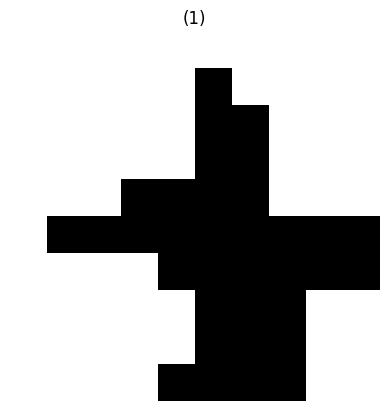

Number of images after splitting: 1


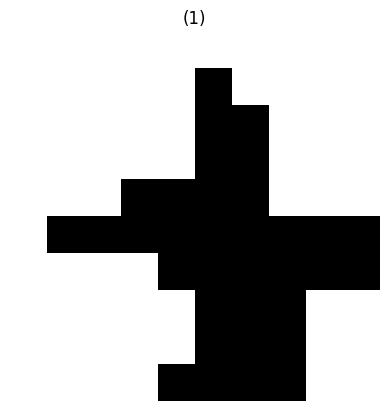

In [1443]:
import cv2
import numpy as np

# Assume l is a list of image arrays
def split_large_image(images,val = 1.6):
    # Step 1: Get column (width) sizes for all images
    col_sizes = [img.shape[1] for img in images]
    avg_col_size = sum(col_sizes) / len(col_sizes)

    # Step 2: Identify the image with double the column size
    for i, img in enumerate(images):
        if img.shape[1] >= val * avg_col_size:  # Flexibility with threshold (e.g., 1.8 instead of 2)
            # Step 3: Split the image vertically into two halves
            mid_col = img.shape[1] // 2
            left_half = img[:, :mid_col]  # Left part
            right_half = img[:, mid_col:]  # Right part

            # Step 4: Replace the large image with the two halves
            images[i] = left_half
            images.insert(i + 1, right_half)
            break  # Stop after splitting the first large image

    return images

# Example usage
# Assuming `l` is your list of image arrays loaded using cv2
# Example loading l = [cv2.imread("image1.png"), cv2.imread("image2.png"), ...]
for i in range(4):
    if len(letters) < 16:
        split_images = split_large_image(letters)
        print(f"Number of images after splitting: {len(split_images)}")
        show_images(letters)


In [1444]:
import cv2
import numpy as np
import os

def preprocess_image(img, dimensions):
    img_resized = cv2.resize(img, dimensions)
    
    # Convert RGBA to RGB if necessary
    if len(img_resized.shape) == 3 and img_resized.shape[2] == 4:
        img_resized = cv2.cvtColor(img_resized, cv2.COLOR_RGBA2RGB)
    
    # Convert to grayscale
    #check if the image is already in grayscale
    if len(img_resized.shape) == 3:
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img_resized
    #show_images([img_gray], ["Gray Image"])

    #now make it binary
    img_binary = np.zeros(img_gray.shape)
    img_binary[img_gray > 0.9] = 255
    #img_binary *= 255
    img_binary = img_binary.astype(np.uint8)
    #show_images([img_binary], ["Binary Image"])
    print(img_gray.max())
    return img_binary

def save_and_preprocess_images(images, dimensions, output_folder):
    """
    Loops through an array of images, preprocesses them, and saves them to a file.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for i, img in enumerate(images):
        # Preprocess image
        img_binary = preprocess_image(img, dimensions)

        # Save the binary image to a file
        output_path = os.path.join(output_folder, f"image_{i}.png")
        cv2.imwrite(output_path, img_binary)
        print(f"Saved: {output_path}")


# Simulated input images (replace with actual images)

output_dir = "output_images1"
dimensions = (185,386)  # Resize dimensions (width, height)

# Process images and save
save_and_preprocess_images(letters, dimensions, output_dir)

1
Saved: output_images1\image_0.png


In [1445]:
import cv2
import os
import numpy as np

# Template matching function
def match_template(image, templates_folder):
    best_match = None
    highest_corr = -1
    
    for digit in range(10):  # Loop through 0-9 folders
        digit_folder = os.path.join(templates_folder, str(digit))
        
        # Check if the digit folder exists
        if not os.path.exists(digit_folder):
            continue
        
        # Loop through all images inside the current digit folder
        for template_filename in os.listdir(digit_folder):
            template_path = os.path.join(digit_folder, template_filename)
            template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
            
            # Ensure the template and image are the same size
            if image.shape == template_img.shape:
                # Perform template matching using normalized cross-correlation
                result = cv2.matchTemplate(image, template_img, cv2.TM_CCOEFF_NORMED)
                corr_value = result[0][0]  # Single value since image size == template size

                # Track the best match
                if corr_value > highest_corr:
                    highest_corr = corr_value
                    best_match = str(digit)
    
    return best_match

# Loop through each letter image
predicted_digits = []
templates_folder = "templates2"  # Path to your templates2 folder
#show_images(letters, ["Letter Image"])

for letter_img in letters:
    #show_images([letter_img])  # Display the current letter

    # Preprocess the image (ensure it matches template dimensions)
    processed_img = preprocess_image(letter_img, (185,386))

    # Perform template matching
    predicted_digit = match_template(processed_img, templates_folder)
    predicted_digits.append(predicted_digit)

# Display the result
print("Predicted Digits:", "".join(predicted_digits))


1
Predicted Digits: 4


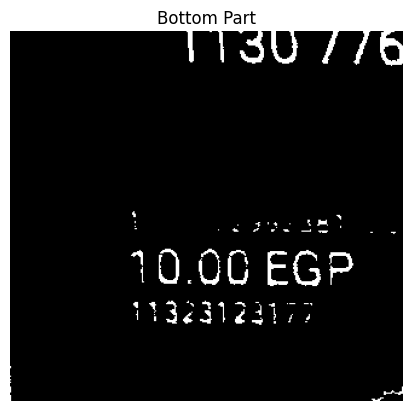

In [1446]:
bottomPart2 = receiptBinaryInverted[int(3*receiptBinaryInverted.shape[0]/4 - 150):int(receiptBinaryInverted.shape[0]-100),
                                     0:int(receiptBinaryInverted.shape[1]/2)].copy()
show_images([bottomPart2], ["Bottom Part"])

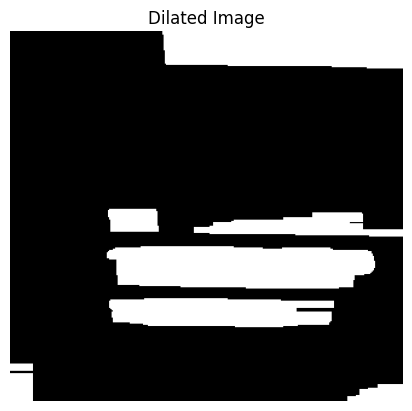

In [1447]:
#temp = binary_opening(bottomPart2,np.ones((3,3)),iterations=1)
binarydilated2 = binary_dilation(bottomPart2,np.ones((3,20)),iterations=2)
show_images([binarydilated2], ["Dilated Image"])

In [1448]:
def findDigitsInDilated(binarydilated, receiptBinaryCropped, numberOfContours):
    """Finds and shows the cropped areas of the largest contour, sorted by vertical position."""
    # Convert binarydilated to uint8 type if it's a boolean array
    
    binarydilated = np.uint8(binarydilated * 255)

    # Find contours in the binary-dilated image
    contours, _ = cv2.findContours(binarydilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    max_area = 0
    max_contour = None
    
    # Iterate through the contours and calculate the area
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour
    
    # If a valid contour is found, calculate its bounding box and crop the region
    if max_contour is not None:
        x, y, w, h = cv2.boundingRect(max_contour)
        cropped_receipt = receiptBinaryCropped[y:y+h, x:x+w]
        return cropped_receipt
    else:
        return None

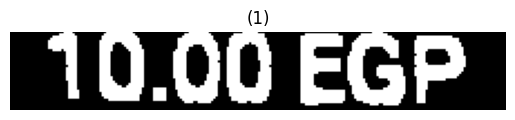

In [1449]:
croppedNumbers = findDigitsInDilated(binarydilated2,bottomPart2,4)
croppedNumbers = binary_dilation(croppedNumbers,np.ones((2,2)),iterations=3)
show_images([croppedNumbers])

Number of contours found: 12
Number of contours after filtering: 7


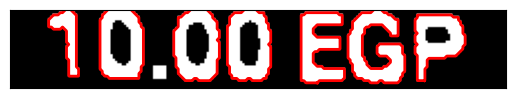

Current min_contour_size: 70
Number of letters: 7


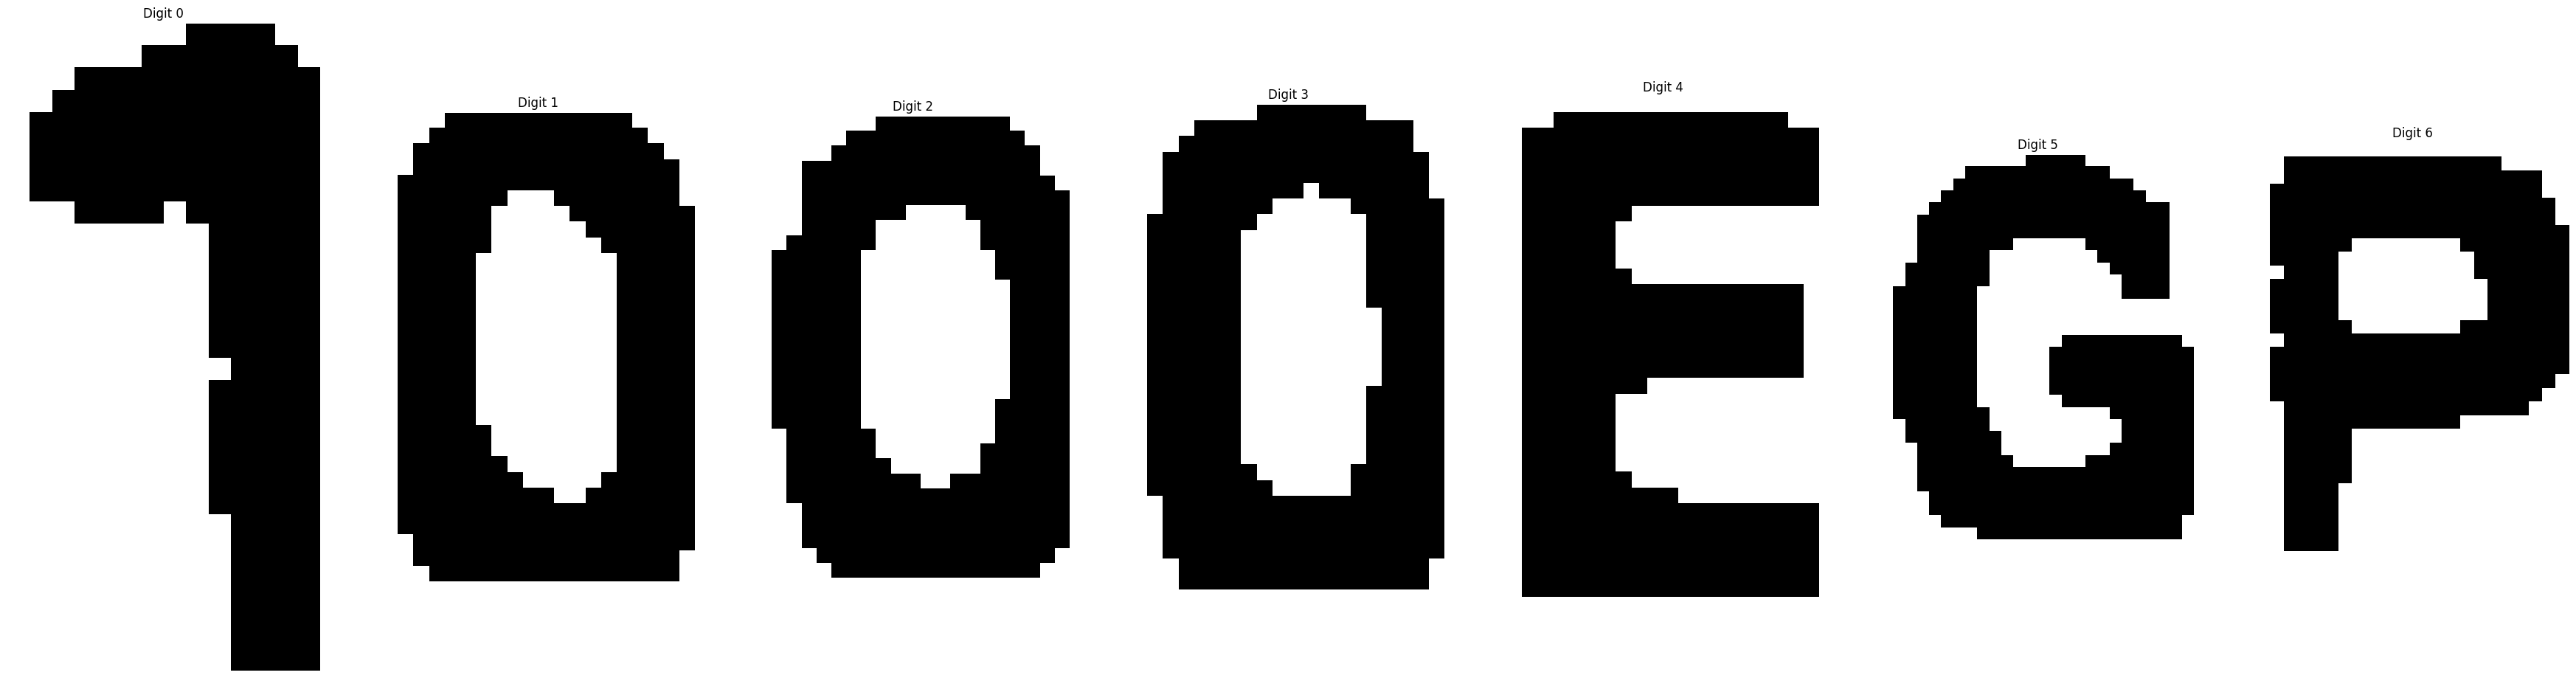

1
7


In [1450]:
img = croppedNumbers

min_contour_size = 70
while True:
    img = croppedNumbers
    process_contours(img,min_contour_size)
    print("Current min_contour_size:", min_contour_size)
    print("Number of letters:", len(letters))
    if len(letters) >= 7 or min_contour_size <= 40:
        break
    min_contour_size -= 5  # Reduce the contour size threshold incrementally
# Show extracted digit images
show_images(letters, ["Digit " + str(i) for i in range(len(letters))])
print(letters[0].max())
print(len(letters))

In [1451]:
for i in range(4):
    if len(letters) < 7:
        split_images = split_large_image(letters,1.4)
        print(f"Number of images after splitting: {len(split_images)}")
        show_images(letters)

In [1452]:


# Template matching function
def match_template_with_symbols(image, templates_folder):
    best_match = None
    highest_corr = -1
    
    # Define folder names and corresponding symbols
    symbol_mapping = {
        "0": "0", "1": "1", "2": "2", "3": "3", "4": "4",
        "5": "5", "6": "6", "7": "7", "8": "8", "9": "9",
        "E": "E", "G": "G", "P": "P", "aa": "."
    }
    
    for folder_name, symbol in symbol_mapping.items():  # Loop through folders
        folder_path = os.path.join(templates_folder, folder_name)
        
        # Check if the folder exists
        if not os.path.exists(folder_path):
            continue
        
        # Loop through all images inside the current folder
        for template_filename in os.listdir(folder_path):
            template_path = os.path.join(folder_path, template_filename)
            template_img = cv2.imread(template_path, cv2.IMREAD_GRAYSCALE)
            
            # Ensure the template and image are the same size
            if image.shape == template_img.shape:
                # Perform template matching using normalized cross-correlation
                result = cv2.matchTemplate(image, template_img, cv2.TM_CCOEFF_NORMED)
                corr_value = result[0][0]  # Single value since image size == template size

                # Track the best match
                if corr_value > highest_corr:
                    highest_corr = corr_value
                    best_match = symbol  # Use the symbol for this folder
    
    return best_match

# Loop through each letter image
predictedPrice = []
templates_folder = "templates2"  # Path to your templates2 folder
letters = letters[:4]
for letter_img in letters:
    # Preprocess the image (ensure it matches template dimensions)
    processed_img = preprocess_image(letter_img, (185, 386))

    # Perform template matching
    predicted_symbol = match_template_with_symbols(processed_img, templates_folder)
    predictedPrice.append(predicted_symbol)
#The insert a dot before the last 2 digits
predictedPrice.insert(-2, ".")
#apped EGP to the end
predictedPrice.append("EGP")


# Display the result
print("Predicted Symbols:", "".join(predictedPrice))


1
1
1
1
Predicted Symbols: 10.00EGP


In [1453]:
print("Predicted Price:", "".join(predictedPrice))
print("Predicted Digits:", "".join(predicted_digits))

Predicted Price: 10.00EGP
Predicted Digits: 4
